# CS6910 Assignment 3 - Sujay and Avyay

In [ ]:
!pip install wandb
!pip install wordcloud
!pip install colour

     |████████████████████████████████| 1.8MB 28.6MB/s 
     |████████████████████████████████| 102kB 13.0MB/s 
     |████████████████████████████████| 133kB 48.3MB/s 
     |████████████████████████████████| 174kB 53.5MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=f6a1302c5d458f5c461a43193af6d10a3803c06451b18666abc1f07c811a54e5
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=67d5f60943705dccc6bc12e9454c85386cd3c0c17a4ad77381558ddcdc9112b4
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [ ]:
## Installing font for Hindi for matplotlib ##
!apt-get install -y fonts-lohit-deva
!fc-list :lang=hi family

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-lohit-deva
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 78.2 kB of archives.
After this operation, 196 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 fonts-lohit-deva all 2.95.4-2 [78.2 kB]
Fetched 78.2 kB in 0s (224 kB/s)
Selecting previously unselected package fonts-lohit-deva.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../fonts-lohit-deva_2.95.4-2_all.deb ...
Unpacking fonts-lohit-deva (2.95.4-2) ...
Setting up fonts-lohit-deva (2.95.4-2) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
Lohit Devanagari


In [ ]:
import os
import random
import time
import wandb
import re, string
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from colour import Color
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the Data

In [ ]:
## Download the dataset ##
import requests
import tarfile

def download_data(save_path):

    data_url = r"https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar"

    r = requests.get(data_url, allow_redirects=True)
    tar_path = "data_assignment3.tar"

    if r.status_code == 200:
        with open(tar_path, 'wb') as f:
            f.write(r.content)

    tar_file = tarfile.open(tar_path)
    tar_file.extractall(save_path)
    tar_file.close()


# downloading and extracting the data to drive 
# uncomment the line below if downloading data for the 1st time
# download_data("/content/drive/MyDrive/DakshinaDataset")

# Data Preprocessing

In [ ]:
# Files with English to Devanagari (Hindi) translation word by word 
# Punctutations have already been cleaned from this file 

def get_data_files(language):
    """ Function fo read data 
    """

    ## REPLACE THIS PATH UPTO dakshina_dataset_v1.0 with your own dataset path ##
    template = "/content/drive/MyDrive/DakshinaDataset/dakshina_dataset_v1.0/{}/lexicons/{}.translit.sampled.{}.tsv"

    train_tsv = template.format(language, language, "train")
    val_tsv = template.format(language, language, "dev")
    test_tsv = template.format(language, language, "test")

    return train_tsv, val_tsv, test_tsv

## Utility functions for preprocessing data ##

def add_start_end_tokens(df, cols, sos="\t", eos="\n"):
    """ Adds EOS and SOS tokens to data 
    """
    def add_tokens(s):  
        # \t = starting token
        # \n = ending token
        return sos + str(s) + eos

    for col in cols:
        df[col] = df[col].apply(add_tokens) 
    
def tokenize(lang, tokenizer=None):
    """ Uses tf.keras tokenizer to tokenize the data/words into characters
    """

    if tokenizer is None:
        tokenizer = Tokenizer(char_level=True)
        tokenizer.fit_on_texts(lang)

        lang_tensor = tokenizer.texts_to_sequences(lang)
        lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,
                                                            padding='post')

    else: 
        lang_tensor = tokenizer.texts_to_sequences(lang)
        lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,
                                                            padding='post')

    return lang_tensor, tokenizer

def preprocess_data(fpath, input_lang_tokenizer=None, targ_lang_tokenizer=None):
    """ Reads, tokenizes and adds SOS/EOS tokens to data based on above functions
    """

    df = pd.read_csv(fpath, sep="\t", header=None)

    # adding start and end tokens to know when to stop predicting 
    add_start_end_tokens(df, [0,1])
    
    input_lang_tensor, input_tokenizer = tokenize(df[1].astype(str).tolist(), 
                                                    tokenizer=input_lang_tokenizer)
    
    targ_lang_tensor, targ_tokenizer = tokenize(df[0].astype(str).tolist(),
                                                    tokenizer=targ_lang_tokenizer) 
    
    dataset = tf.data.Dataset.from_tensor_slices((input_lang_tensor, targ_lang_tensor))
    dataset = dataset.shuffle(len(dataset))
    
    return dataset, input_tokenizer, targ_tokenizer

# Model Building

In [ ]:
## Utility functions ##
def get_layer(name, units, dropout, return_state=False, return_sequences=False):

    if name=="rnn":
        return layers.SimpleRNN(units=units, dropout=dropout, 
                                return_state=return_state,
                                return_sequences=return_sequences)

    if name=="gru":
        return layers.GRU(units=units, dropout=dropout, 
                          return_state=return_state,
                          return_sequences=return_sequences)

    if name=="lstm":
        return layers.LSTM(units=units, dropout=dropout, 
                           return_state=return_state,
                           return_sequences=return_sequences)

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, enc_state, enc_out):
    
    enc_state = tf.concat(enc_state, 1)
    enc_state = tf.expand_dims(enc_state, 1)

    score = self.V(tf.nn.tanh(self.W1(enc_state) + self.W2(enc_out)))

    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * enc_out
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights


class Encoder(tf.keras.Model):
    def __init__(self, layer_type, n_layers, units, encoder_vocab_size, embedding_dim, dropout):
        super(Encoder, self).__init__()
        self.layer_type = layer_type
        self.n_layers = n_layers
        self.units = units
        self.dropout = dropout
        self.embedding = tf.keras.layers.Embedding(encoder_vocab_size, embedding_dim)
        self.create_rnn_layers()

    def call(self, x, hidden):
        x = self.embedding(x)
        x = self.rnn_layers[0](x, initial_state=hidden)

        for layer in self.rnn_layers[1:]:
            x = layer(x)

        output, state = x[0], x[1:]

        return output, state
    
    def create_rnn_layers(self):
        self.rnn_layers = []

        for i in range(self.n_layers):
            self.rnn_layers.append(get_layer(self.layer_type, self.units, self.dropout,
                                                return_sequences=True,
                                                return_state=True))


    def initialize_hidden_state(self, batch_size):

        if self.layer_type != "lstm":
            return [tf.zeros((batch_size, self.units))]
        else:
            return [tf.zeros((batch_size, self.units))]*2

class Decoder(tf.keras.Model):
    def __init__(self, layer_type, n_layers, units, decoder_vocab_size, embedding_dim, dropout, attention=False):
        super(Decoder, self).__init__()

        self.layer_type = layer_type
        self.n_layers = n_layers
        self.units = units
        self.dropout = dropout
        self.attention = attention
        self.embedding_layer = layers.Embedding(input_dim=decoder_vocab_size, 
                                                output_dim=embedding_dim)
        
        self.dense = layers.Dense(decoder_vocab_size, activation="softmax")
        self.flatten = layers.Flatten()
        if self.attention:
            self.attention_layer = BahdanauAttention(self.units)
        self.create_rnn_layers()

    def call(self, x, hidden, enc_out=None):
        
        x = self.embedding_layer(x)

        if self.attention:
            context_vector, attention_weights = self.attention_layer(hidden, enc_out)
            x = tf.concat([tf.expand_dims(context_vector, 1), x], -1)
        else:
            attention_weights = None

        x = self.rnn_layers[0](x, initial_state=hidden)

        for layer in self.rnn_layers[1:]:
            x = layer(x)

        output, state = x[0], x[1:]

        output = self.dense(self.flatten(output))
        
        return output, state, attention_weights

    def create_rnn_layers(self):
        self.rnn_layers = []    

        for i in range(self.n_layers - 1):
            self.rnn_layers.append(get_layer(self.layer_type, self.units, self.dropout,
                                                return_sequences=True,
                                                return_state=True))
        
        self.rnn_layers.append(get_layer(self.layer_type, self.units, self.dropout,
                                            return_sequences=False,
                                            return_state=True))

In [ ]:
class BeamSearch():
    def __init__(self, model, k):
        self.k = k 
        self.model = model
        self.acc = tf.keras.metrics.Accuracy()

    def sample_beam_search(self, probs):

        m, n = probs.shape
        output_sequences = [[[], 0.0]]

        for row in probs:
            beams = []

            for tup in output_sequences:
                seq, score = tup
                for j in range(n):
                    new_beam = [seq + [j], score - tf.math.log(row[j])]
                    beams.append(new_beam)

            output_sequences = sorted(beams, key=lambda x: x[1])[:self.k]

        tensors, scores = list(zip(*output_sequences))
        tensors = list(map(lambda x: tf.expand_dims(tf.constant(x),0), tensors))

        return tf.concat(tensors, 0), scores

    def beam_accuracy(self, input, target):
        accs = []

        for i in range(self.k):
            self.acc.reset_states()
            self.acc.update_state(target, input[i, :])  
            accs.append(self.acc.result())

        return max(accs)
    
    def step(self, input, target, enc_state):

        batch_acc = 0
        sequences = []

        enc_out, enc_state = self.model.encoder(input, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.model.targ_tokenizer.word_index["\t"]]*self.model.batch_size ,1)

        for t in range(1, target.shape[1]):

            preds, dec_state, _ = self.model.decoder(dec_input, dec_state, enc_out)

            sequences.append(preds)
            preds = tf.argmax(preds, 1)
            dec_input = tf.expand_dims(preds, 1)

        sequences = tf.concat(list(map(lambda x: tf.expand_dims(x, 1), sequences)), axis=1)

        for i in range(target.shape[0]):

            possibilities, scores = self.sample_beam_search(sequences[i, :, :])
            batch_acc += self.beam_accuracy(possibilities, target[i, 1:])

        batch_acc = batch_acc / target.shape[0]

        return 0, batch_acc

    def evaluate(self, test_dataset, batch_size=None, upto=5, use_wandb=False):
        
        if batch_size is not None:
            self.model.batch_size = batch_size
            test_dataset = test_dataset.batch(batch_size)
        else:
            self.model.batch_size = 1

        test_acc = 0
        enc_state = self.model.encoder.initialize_hidden_state(self.model.batch_size)

        for batch, (input, target) in enumerate(test_dataset.take(upto)):
           
           _, acc = self.step(input, target, enc_state)
           test_acc += acc

        if use_wandb:
            wandb.log({"test acc (beam search)": test_acc / upto})

        print(f"Test Accuracy on {upto*batch_size} samples: {test_acc / upto:.4f}\n")

    def translate(self, word):

        word = "\t" + word + "\n"
        sequences = []
        result = []

        inputs = self.model.input_tokenizer.texts_to_sequences([word])
        inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                               maxlen=self.model.max_input_len,
                                                               padding="post")


        enc_state = self.model.encoder.initialize_hidden_state(1)
        enc_out, enc_state = self.model.encoder(inputs, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.model.targ_tokenizer.word_index["\t"]]*1, 1)

        for t in range(1, self.model.max_target_len):

            preds, dec_state, _ = self.model.decoder(dec_input, dec_state, enc_out)

            sequences.append(preds)
            preds = tf.argmax(preds, 1)
            dec_input = tf.expand_dims(preds, 1)

        sequences = tf.concat(list(map(lambda x: tf.expand_dims(x, 1), sequences)), axis=1)

        possibilities, scores = self.sample_beam_search(tf.squeeze(sequences, 0))
        output_words = self.model.targ_tokenizer.sequences_to_texts(possibilities.numpy())
        
        def post_process(word):
            word = word.split(" ")[:-1]
            return "".join([x for x in word])

        output_words = list(map(post_process, output_words))

        return output_words, scores

In [ ]:
class Seq2SeqModel():
    def __init__(self, embedding_dim, encoder_layers, decoder_layers, layer_type, units, dropout, attention=False):
        self.embedding_dim = embedding_dim
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers
        self.layer_type = layer_type
        self.units = units
        self.dropout = dropout
        self.attention = attention
        self.stats = []
        self.batch_size = 128
        self.use_beam_search = False

    def build(self, loss, optimizer, metric):
        self.loss = loss
        self.optimizer = optimizer
        self.metric = metric

    def set_vocabulary(self, input_tokenizer, targ_tokenizer):
        self.input_tokenizer = input_tokenizer
        self.targ_tokenizer = targ_tokenizer
        self.create_model()
    
    def create_model(self):

        encoder_vocab_size = len(self.input_tokenizer.word_index) + 1
        decoder_vocab_size = len(self.targ_tokenizer.word_index) + 1

        self.encoder = Encoder(self.layer_type, self.encoder_layers, self.units, encoder_vocab_size,
                               self.embedding_dim, self.dropout)

        self.decoder = Decoder(self.layer_type, self.decoder_layers, self.units, decoder_vocab_size,
                               self.embedding_dim,  self.dropout, self.attention)

    @tf.function
    def train_step(self, input, target, enc_state):

        loss = 0 

        with tf.GradientTape() as tape: 

            enc_out, enc_state = self.encoder(input, enc_state)

            dec_state = enc_state
            dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*self.batch_size ,1)

            ## We use Teacher forcing to train the network
            ## Each target at timestep t is passed as input for timestep t + 1

            if random.random() < self.teacher_forcing_ratio:

                for t in range(1, target.shape[1]):

                    preds, dec_state, _ = self.decoder(dec_input, dec_state, enc_out)
                    loss += self.loss(target[:,t], preds)
                    self.metric.update_state(target[:,t], preds)
                    
                    dec_input = tf.expand_dims(target[:,t], 1)
            
            else:

                for t in range(1, target.shape[1]):

                    preds, dec_state, _ = self.decoder(dec_input, dec_state, enc_out)
                    loss += self.loss(target[:,t], preds)
                    self.metric.update_state(target[:,t], preds)

                    preds = tf.argmax(preds, 1)
                    dec_input = tf.expand_dims(preds, 1)


            batch_loss = loss / target.shape[1]

            variables = self.encoder.variables + self.decoder.variables
            gradients = tape.gradient(loss, variables)

            self.optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss, self.metric.result()

    @tf.function
    def validation_step(self, input, target, enc_state):

        loss = 0
        
        enc_out, enc_state = self.encoder(input, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*self.batch_size ,1)

        for t in range(1, target.shape[1]):

            preds, dec_state, _ = self.decoder(dec_input, dec_state, enc_out)
            loss += self.loss(target[:,t], preds)
            self.metric.update_state(target[:,t], preds)

            preds = tf.argmax(preds, 1)
            dec_input = tf.expand_dims(preds, 1)

        batch_loss = loss / target.shape[1]
        
        return batch_loss, self.metric.result()


    def fit(self, dataset, val_dataset, batch_size=128, epochs=10, use_wandb=False, teacher_forcing_ratio=1.0):

        self.batch_size = batch_size
        self.teacher_forcing_ratio = teacher_forcing_ratio

        steps_per_epoch = len(dataset) // self.batch_size
        steps_per_epoch_val = len(val_dataset) // self.batch_size
        
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        val_dataset = val_dataset.batch(self.batch_size, drop_remainder=True)

        # useful when we need to translate the sentence
        sample_inp, sample_targ = next(iter(dataset))
        self.max_target_len = sample_targ.shape[1]
        self.max_input_len = sample_inp.shape[1]

        template = "\nTrain Loss: {0:.4f} Train Accuracy: {1:.4f} Validation Loss: {2:.4f} Validation Accuracy: {3:.4f}"

        print("-"*100)
        for epoch in range(1, epochs+1):
            print(f"EPOCH {epoch}\n")

            ## Training loop ##
            total_loss = 0
            total_acc = 0
            self.metric.reset_states()

            starting_time = time.time()
            enc_state = self.encoder.initialize_hidden_state(self.batch_size)

            print("Training ...\n")
            for batch, (input, target) in enumerate(dataset.take(steps_per_epoch)):
                batch_loss, acc = self.train_step(input, target, enc_state)
                total_loss += batch_loss
                total_acc += acc


                if batch==0 or ((batch + 1) % 100 == 0):
                    print(f"Batch {batch+1} Loss {batch_loss:.4f}")

            avg_acc = total_acc / steps_per_epoch
            avg_loss = total_loss / steps_per_epoch

            # Validation loop ##
            total_val_loss = 0
            total_val_acc = 0
            self.metric.reset_states()

            enc_state = self.encoder.initialize_hidden_state(self.batch_size)

            print("\nValidating ...")
            for batch, (input, target) in enumerate(val_dataset.take(steps_per_epoch_val)):
                batch_loss, acc = self.validation_step(input, target, enc_state)
                total_val_loss += batch_loss
                total_val_acc += acc

            avg_val_acc = total_val_acc / steps_per_epoch_val
            avg_val_loss = total_val_loss / steps_per_epoch_val

            print(template.format(avg_loss, avg_acc*100, avg_val_loss, avg_val_acc*100))
            
            time_taken = time.time() - starting_time
            self.stats.append({"epoch": epoch,
                            "train loss": avg_loss,
                            "val loss": avg_val_loss,
                            "train acc": avg_acc*100,
                            "val acc": avg_val_acc*100,
                            "training time": time_taken})
            
            if use_wandb:
                wandb.log(self.stats[-1])
            
            print(f"\nTime taken for the epoch {time_taken:.4f}")
            print("-"*100)
        
        print("\nModel trained successfully !!")
        
    def evaluate(self, test_dataset, batch_size=None):

        if batch_size is not None:
            self.batch_size = batch_size

        steps_per_epoch_test = len(test_dataset) // batch_size
        test_dataset = test_dataset.batch(batch_size, drop_remainder=True)
        
        total_test_loss = 0
        total_test_acc = 0
        self.metric.reset_states()

        enc_state = self.encoder.initialize_hidden_state(self.batch_size)

        print("\nRunning test dataset through the model...\n")
        for batch, (input, target) in enumerate(test_dataset.take(steps_per_epoch_test)):
            batch_loss, acc = self.validation_step(input, target, enc_state)
            total_test_loss += batch_loss
            total_test_acc += acc

        avg_test_acc = total_test_acc / steps_per_epoch_test
        avg_test_loss = total_test_loss / steps_per_epoch_test
    
        print(f"Test Loss: {avg_test_loss:.4f} Test Accuracy: {avg_test_acc:.4f}")

        return avg_test_loss, avg_test_acc


    def translate(self, word, get_heatmap=False):

        word = "\t" + word + "\n"

        inputs = self.input_tokenizer.texts_to_sequences([word])
        inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                               maxlen=self.max_input_len,
                                                               padding="post")

        result = ""
        att_wts = []

        enc_state = self.encoder.initialize_hidden_state(1)
        enc_out, enc_state = self.encoder(inputs, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*1, 1)

        for t in range(1, self.max_target_len):

            preds, dec_state, attention_weights = self.decoder(dec_input, dec_state, enc_out)
            
            if get_heatmap:
                att_wts.append(attention_weights)
            
            preds = tf.argmax(preds, 1)
            next_char = self.targ_tokenizer.index_word[preds.numpy().item()]
            result += next_char

            dec_input = tf.expand_dims(preds, 1)

            if next_char == "\n":
                return result[:-1], att_wts[:-1]

        return result[:-1], att_wts[:-1]

    def plot_attention_heatmap(self, word, ax, font_path="/usr/share/fonts/truetype/lohit-devanagari/Lohit-Devanagari.ttf"):

        translated_word, attn_wts = self.translate(word, get_heatmap=True)
        attn_heatmap = tf.squeeze(tf.concat(attn_wts, 0), -1).numpy()

        input_word_len = len(word)
        output_word_len = len(translated_word)

        ax.imshow(attn_heatmap[:, :input_word_len])

        font_prop = FontProperties(fname=font_path, size=18)

        ax.set_xticks(np.arange(input_word_len))
        ax.set_yticks(np.arange(output_word_len))

        ax.set_xticklabels(list(word))
        ax.set_yticklabels(list(translated_word), fontproperties=font_prop)


# Visualizing Model Outputs

In [ ]:
def get_colors(inputs, targets, preds):

    n = len(targets)
    smoother = SmoothingFunction().method2
    def get_scores(target, output, smoother):
        return sentence_bleu(list(list(target)), list(output), smoothing_function=smoother)

    red = Color("red")
    colors = list(red.range_to(Color("violet"),n))
    colors = list(map(lambda c: c.hex, colors))

    scores = []
    for i in range(n):
        scores.append(get_scores(targets[i], preds[i], smoother))

    d = dict(zip(sorted(scores), list(range(n))))
    ordered_colors = list(map(lambda x: colors[d[x]], scores))
    
    input_colors = dict(zip(inputs, ordered_colors))
    target_colors = dict(zip(targets, ordered_colors))
    pred_colors = dict(zip(preds, ordered_colors))

    return input_colors, target_colors, pred_colors


class Colorizer():
    def __init__(self, word_to_color, default_color):
       
        self.word_to_color = word_to_color
        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)

def randomly_evaluate(model, test_file=get_data_files("hi")[2], n=10):

    df = pd.read_csv(test_file, sep="\t", header=None)
    df = df.sample(n=n).reset_index(drop=True)

    print(f"Randomly evaluating the model on {n} words\n")

    for i in range(n):
        word = str(df[1][i])

        print(f"Input word: {word}")
        print(f"Actual translation: {str(df[0][i])}")
        print(f"Model translation: {model.translate(word)[0]}\n")

def visualize_model_outputs(model, test_file=get_data_files("hi")[2], n=10, font_path="/usr/share/fonts/truetype/lohit-devanagari/Lohit-Devanagari.ttf"):

    df = pd.read_csv(test_file, sep="\t", header=None)
    df = df.sample(n=n).reset_index(drop=True)

    inputs = df[1].astype(str).tolist()
    targets = df[0].astype(str).tolist()
    preds = list(map(lambda word: model.translate(word)[0], inputs))

    # Generate colors for the words
    input_colors, target_colors, pred_colors =  get_colors(inputs, targets, preds)
    color_fn_ip = Colorizer(input_colors, "white")
    color_fn_tr = Colorizer(target_colors, "white")
    color_fn_op = Colorizer(pred_colors, "white")

    input_text = Counter(inputs)
    target_text = Counter(targets)
    output_text = Counter(preds)

    fig, axs = plt.subplots(1,3, figsize=(30, 15))
    plt.tight_layout()

    wc_in = WordCloud(random_state=1).generate_from_frequencies(input_text)
    wc_out = WordCloud(font_path=font_path, random_state=1).generate_from_frequencies(output_text)
    wc_tar = WordCloud(font_path=font_path, random_state=1).generate_from_frequencies(target_text)

    axs[0].set_title("Input words", fontsize=30)
    axs[0].imshow(wc_in.recolor(color_func=color_fn_ip))
    axs[1].set_title("Target words", fontsize=30)
    axs[1].imshow(wc_tar.recolor(color_func=color_fn_tr))
    axs[2].set_title("Model outputs", fontsize=30)
    axs[2].imshow(wc_out.recolor(color_func=color_fn_op))
    plt.show()
    


def test_on_dataset(language, embedding_dim, encoder_layers, decoder_layers, layer_type, units, dropout, attention, teacher_forcing_ratio=1.0, save_outputs=None):
    
    TRAIN_TSV, VAL_TSV, TEST_TSV = get_data_files(language)

    model = Seq2SeqModel(embedding_dim, 
                         encoder_layers, 
                         decoder_layers, 
                         layer_type, 
                         units,
                         dropout,
                         attention)

    dataset, input_tokenizer, targ_tokenizer = preprocess_data(TRAIN_TSV)
    val_dataset, _, _ = preprocess_data(VAL_TSV, input_tokenizer, targ_tokenizer)

    model.set_vocabulary(input_tokenizer, targ_tokenizer)
    model.build(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metric = tf.keras.metrics.SparseCategoricalAccuracy())
    
    model.fit(dataset, val_dataset, epochs=30, use_wandb=False, teacher_forcing_ratio=teacher_forcing_ratio)

    ## Character level accuracy ##
    test_dataset, _, _ = preprocess_data(TEST_TSV, model.input_tokenizer, model.targ_tokenizer)
    test_loss, test_acc = model.evaluate(test_dataset, batch_size=100)

    ##  Word level accuracy ##
    test_tsv = pd.read_csv(TEST_TSV, sep="\t", header=None)
    inputs = test_tsv[1].astype(str).tolist()
    targets = test_tsv[0].astype(str).tolist()
    
    outputs = []

    for word in inputs:
        outputs.append(model.translate(word)[0])

    def word_level_acc(outputs, targets):
        return np.sum(np.asarray(outputs) == np.array(targets)) / len(outputs)

    print(f"Word level accuracy: {word_level_acc(outputs, targets)}")

    if save_outputs is not None:
        df = pd.DataFrame()
        df["inputs"] = inputs
        df["targets"] = targets
        df["outputs"] = outputs
        df.to_csv(save_outputs)


    return model

#randomly_evaluate(model, n=15)

# Visualizing Model Connectivity (Q6)

In [ ]:
# Tools for getting model connectivity between input and output characters
def get_lstm_output(decoder, x, hidden, enc_out=None):
    
    x = decoder.embedding_layer(x)

    if decoder.attention:
        context_vector, attention_weights = decoder.attention_layer(hidden, enc_out)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], -1)
    else:
        attention_weights = None

    x = decoder.rnn_layers[0](x, initial_state=hidden)

    for layer in decoder.rnn_layers[1:]:
        x = layer(x)

    output, state = x[0], x[1:]

    #output = decoder.dense(decoder.flatten(output))
    
    return output, state, attention_weights

def get_output_from_embedding(encoder, x, hidden):

    x = encoder.rnn_layers[0](x, initial_state=hidden)

    for layer in encoder.rnn_layers[1:]:
        x = layer(x)

    output, state = x[0], x[1:]

    return output, state


def get_connectivity(model, word):

    word = "\t" + word + "\n"

    inputs = model.input_tokenizer.texts_to_sequences([word])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                            maxlen=model.max_input_len,
                                                            padding="post")

    result = ""

    gradient_list = []

    enc_state = model.encoder.initialize_hidden_state(1)
    embedded_in = model.encoder.embedding(inputs)


    with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
        tape.watch(embedded_in)

        enc_out, enc_state = get_output_from_embedding(model.encoder, embedded_in, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([model.targ_tokenizer.word_index["\t"]]*1, 1)

        for t in range(1, model.max_target_len):

            lstm_out, dec_state, _ = get_lstm_output(model.decoder, dec_input, dec_state, enc_out)

            preds = model.decoder.dense(model.decoder.flatten(lstm_out))
            gradient_list.append(tape.gradient(lstm_out, embedded_in)[0])
            
            preds = tf.argmax(preds, 1)
            next_char = model.targ_tokenizer.index_word[preds.numpy().item()]
            result += next_char

            dec_input = tf.expand_dims(preds, 1)

            if next_char == "\n":
                return result[:-1], gradient_list[:-1]

        return result[:-1], gradient_list[:-1]

In [ ]:
# Imports for visualising the model connectivity
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from IPython.display import HTML as html_print
from IPython.display import display
import tensorflow.keras.backend as K

# get html element
def cstr(s, color='black'):
    if s == ' ':
      return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
    else:
      return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)
	
# print html
def print_color(t):
	  display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

# get appropriate color for value
def get_clr(value):
    colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
      '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
      '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
      '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
    value = int(value * 19)
    if value == 19:
        value -= 1
    return colors[value]

# sigmoid function
def sigmoid(x):
    z = 1/(1 + np.exp(-x)) 
    return z

def softmax(x):
    v = np.exp(x)
    v = v / np.sum(v)
    return v

def get_gradient_norms(grad_list, word, activation="sigmoid"):
    grad_norms = []
    for grad_tensor in grad_list:
        grad_mags = tf.norm(grad_tensor, axis=1)
        grad_mags = grad_mags[:len(word)]
        if activation == "softmax":
            grad_mags_scaled = softmax(grad_mags)
        elif activation == "scaler":
            scaler = MinMaxScaler()
            grad_mags = tf.reshape(grad_mags, (-1,1))
            grad_mags_scaled = scaler.fit_transform(grad_mags)
        else:
            grad_mags_scaled = sigmoid(grad_mags)
        grad_norms.append(grad_mags_scaled)
    return grad_norms

def visualize(grad_norms, word, translated_word):
    print("Original Word:", word)
    print("Transliterated Word:", translated_word)
    for i in range(len(translated_word)):
        print("Connectivity Visualization for", translated_word[i],":")
        text_colours = []
        for j in range(len(grad_norms[i])):
            text = (word[j], get_clr(grad_norms[i][j]))
            text_colours.append(text)
        print_color(text_colours)

def visualise_connectivity(model, word, activation="sigmoid"):
    translated_word, grad_list = get_connectivity(model, word)
    grad_norms = get_gradient_norms(grad_list, word, activation)
    visualize(grad_norms, word, translated_word)

In [ ]:
model = test_on_dataset(language="hi",
                        embedding_dim=256,
                        encoder_layers=3,
                        decoder_layers=3,
                        layer_type="lstm",
                        units=256,
                        dropout=0.2,
                        attention=False)

----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9886
Batch 100 Loss 1.1730
Batch 200 Loss 0.9675
Batch 300 Loss 0.8902

Validating ...

Train Loss: 1.0974 Train Accuracy: 67.1118 Validation Loss: 2.7479 Validation Accuracy: 45.2474

Time taken for the epoch 100.8130
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.8948
Batch 100 Loss 0.8160
Batch 200 Loss 0.8000
Batch 300 Loss 0.7038

Validating ...

Train Loss: 0.8094 Train Accuracy: 75.1404 Validation Loss: 2.9857 Validation Accuracy: 48.1885

Time taken for the epoch 27.0900
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.7246
Batch 100 Loss 0.6105
Batch 200 Loss 0.5454
Batch 300 Loss 0.4892

Validating ...

Train Loss: 0.5672 Train Accuracy: 80.7534 Validation Loss

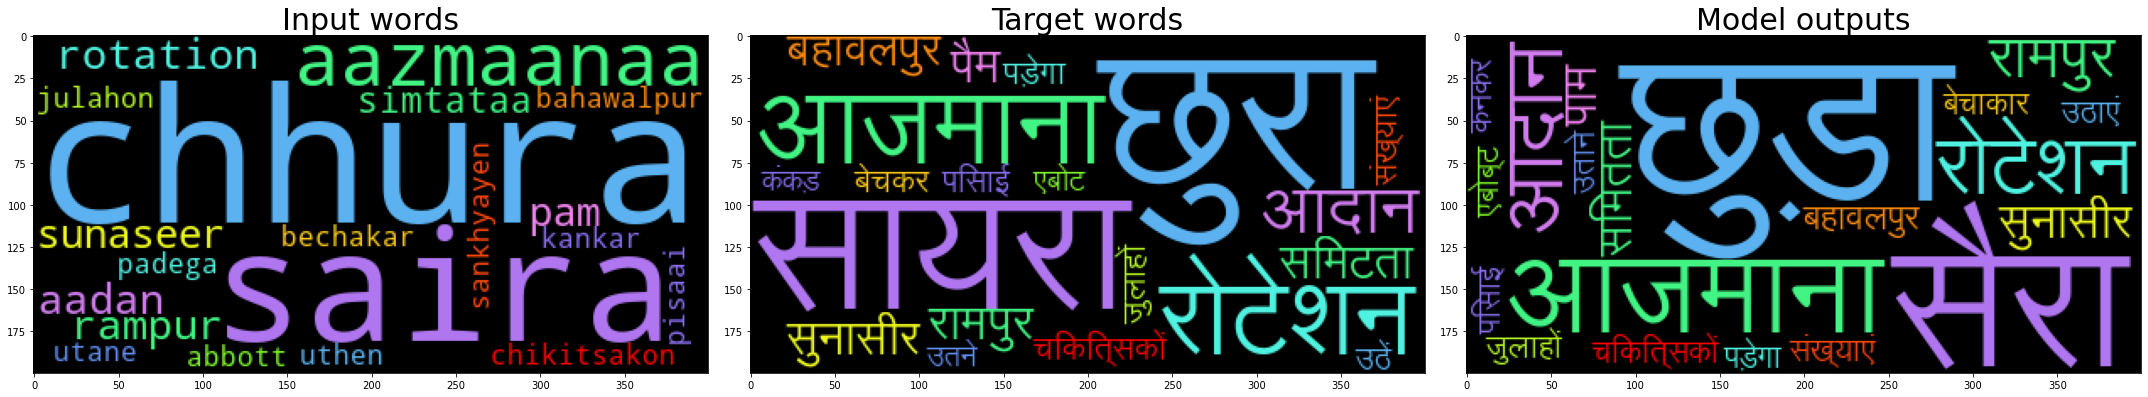

In [ ]:
visualize_model_outputs(model, n=20)

In [ ]:
def get_test_words(n):
    test_df = pd.read_csv(get_data_files("hi")[2])
    test_sample = test_df.sample(n)
    test_sample.reset_index(inplace=True, drop=True)
    test_words = []
    for i in test_sample.index:
        entry = test_sample["अंक\tank\t5"].loc[i]
        parts = entry.split("\t")
        word = parts[1]
        test_words.append(word)
    return test_words

test_words = get_test_words(5)
print(test_words)

['laurens', 'jivaniyaan', 'karykartaon', 'vaishakh', 'caolan']


In [ ]:
for word in test_words:
    visualise_connectivity(model, word, activation="scaler")

Original Word: laurens
Transliterated Word: लारेंस
Connectivity Visualization for ल :


Connectivity Visualization for ा :


Connectivity Visualization for र :


Connectivity Visualization for े :


Connectivity Visualization for ं :


Connectivity Visualization for स :


Original Word: jivaniyaan
Transliterated Word: जीवाणियां
Connectivity Visualization for ज :


Connectivity Visualization for ी :


Connectivity Visualization for व :


Connectivity Visualization for ा :


Connectivity Visualization for ण :


Connectivity Visualization for ि :


Connectivity Visualization for य :


Connectivity Visualization for ा :


Connectivity Visualization for ं :


Original Word: karykartaon
Transliterated Word: कार्यकर्ताओं
Connectivity Visualization for क :


Connectivity Visualization for ा :


Connectivity Visualization for र :


Connectivity Visualization for ् :


Connectivity Visualization for य :


Connectivity Visualization for क :


Connectivity Visualization for र :


Connectivity Visualization for ् :


Connectivity Visualization for त :


Connectivity Visualization for ा :


Connectivity Visualization for ओ :


Connectivity Visualization for ं :


Original Word: vaishakh
Transliterated Word: वैशाख
Connectivity Visualization for व :


Connectivity Visualization for ै :


Connectivity Visualization for श :


Connectivity Visualization for ा :


Connectivity Visualization for ख :


Original Word: caolan
Transliterated Word: कैलन
Connectivity Visualization for क :


Connectivity Visualization for ै :


Connectivity Visualization for ल :


Connectivity Visualization for न :


In [ ]:
randomly_evaluate(model, n=5)

Randomly evaluating the model on 5 words

Input word: lochdar
Actual translation: लोचदार
Model translation: लोचदार

Input word: qawwaliyon
Actual translation: कव्वालियों
Model translation: क्ववेलियों

Input word: unatees
Actual translation: उनतीस
Model translation: युमालिद

Input word: bhabar
Actual translation: भाबर
Model translation: भाबर

Input word: raalod
Actual translation: रालोद
Model translation: रालोद



# WandB Function

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
def train_with_wandb(language, test_beam_search=False):

    config_defaults = {"embedding_dim": 64, 
                       "enc_dec_layers": 1,
                       "layer_type": "lstm",
                       "units": 128,
                       "dropout": 0,
                       "attention": False,
                       "beam_width": 3,
                       "teacher_forcing_ratio": 1.0
                       }

    wandb.init(config=config_defaults, project="cs6910-assignment3", resume=True)
    # Below is an example of a custom run name for sweep 4
    # This line was different for all sweeps
    #wandb.run.name = f"beam_width_{wandb.config.beam_width}"

    ## 1. SELECT LANGUAGE ##
    TRAIN_TSV, VAL_TSV, TEST_TSV = get_data_files(language)

    ## 2. DATA PREPROCESSING ##
    dataset, input_tokenizer, targ_tokenizer = preprocess_data(TRAIN_TSV)
    val_dataset, _, _ = preprocess_data(VAL_TSV, input_tokenizer, targ_tokenizer)

    ## 3. CREATING THE MODEL ##
    model = Seq2SeqModel(embedding_dim=wandb.config.embedding_dim,
                         encoder_layers=wandb.config.enc_dec_layers,
                         decoder_layers=wandb.config.enc_dec_layers,
                         layer_type=wandb.config.layer_type,
                         units=wandb.config.units,
                         dropout=wandb.config.dropout,
                         attention=wandb.config.attention)
    
    ## 4. COMPILING THE MODEL 
    model.set_vocabulary(input_tokenizer, targ_tokenizer)
    model.build(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metric = tf.keras.metrics.SparseCategoricalAccuracy())
    
    ## 5. FITTING AND VALIDATING THE MODEL
    model.fit(dataset, val_dataset, epochs=30, use_wandb=True, teacher_forcing_ratio=wandb.config.teacher_forcing_ratio)

    if test_beam_search:
        ## OPTIONAL :- Evaluate the dataset using beam search and without beam search
        val_dataset, _, _ = preprocess_data(VAL_TSV, model.input_tokenizer, model.targ_tokenizer)
        subset = val_dataset.take(500)

        # a) Without beam search
        _, test_acc_without = model.evaluate(subset, batch_size=100) 
        wandb.log({"test acc": test_acc_without})
        
        # b) With beam search
        beam_search = BeamSearch(model=model, k=wandb.config.beam_width)
        beam_search.evaluate(subset, batch_size=100, use_wandb=True)

# Sweeps without Attention

In [ ]:
sweep_config = {
  "name": "Sweep 1- Assignment3",
  "method": "grid",
  "parameters": {
        "enc_dec_layers": {
           "values": [1, 2, 3]
        },
        "units": {
            "values": [64, 128, 256]
        },
        "layer_type": {
            "values": ["rnn", "gru", "lstm"]
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="cs6910-assignment3")

Create sweep with ID: lblxi0ef
Sweep URL: https://wandb.ai/avyay-sujay/cs6910-assignment3/sweeps/lblxi0ef


In [ ]:
wandb.agent(sweep_id, function=lambda: train_with_wandb("hi"))

wandb: Agent Starting Run: og012kq3 with config:
wandb: 	enc_dec_layers: 2
wandb: 	layer_type: lstm
wandb: 	units: 128
wandb: Currently logged in as: avyay-sujay (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9881
Batch 100 Loss 1.1191
Batch 200 Loss 1.0513
Batch 300 Loss 0.9881

Validating ...

Train Loss: 1.2073 Train Accuracy: 66.3275 Validation Loss: 2.1706 Validation Accuracy: 54.2569

Time taken for the epoch 104.3939
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.9592
Batch 100 Loss 1.0006
Batch 200 Loss 0.9192
Batch 300 Loss 0.8827

Validating ...

Train Loss: 0.9404 Train Accuracy: 72.2395 Validation Loss: 2.1683 Validation Accuracy: 53.7401

Time taken for the epoch 20.2066
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.8280
Batch 100 Loss 0.8341
Batch 200 Loss 0.7646
Batch 300 Loss 0.7220

Validating ...

Train Loss: 0.8029 Train Accuracy: 75.5296 Validation Loss

epoch,30
train loss,0.08196
val loss,1.61336
train acc,97.43398
val acc,80.85928
training time,20.46491
_runtime,696
_timestamp,1620210920
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▆▅▅▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val loss,▆▆▆██▆▅▃▄▃▃▂▂▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▃▂
train acc,▁▂▃▄▄▅▆▆▆▇▇▇▇▇▇▇▇▇████████████
val acc,▁▁▁▁▂▃▄▅▅▆▆▇▇▇▇███████████████
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 88xo1un6 with config:
wandb: 	enc_dec_layers: 2
wandb: 	layer_type: lstm
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9867
Batch 100 Loss 1.1116
Batch 200 Loss 0.9972
Batch 300 Loss 0.8891

Validating ...

Train Loss: 1.1379 Train Accuracy: 66.5033 Validation Loss: 2.2488 Validation Accuracy: 51.3899

Time taken for the epoch 74.6163
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.9176
Batch 100 Loss 0.9480
Batch 200 Loss 0.8715
Batch 300 Loss 0.7922

Validating ...

Train Loss: 0.8640 Train Accuracy: 74.2525 Validation Loss: 2.8922 Validation Accuracy: 47.5752

Time taken for the epoch 20.7075
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.7812
Batch 100 Loss 0.7796
Batch 200 Loss 0.7355
Batch 300 Loss 0.6677

Validating ...

Train Loss: 0.7340 Train Accuracy: 76.9955 Validation Loss:

epoch,30
train loss,0.02929
val loss,2.02159
train acc,99.12923
val acc,80.46803
training time,20.39681
_runtime,681
_timestamp,1620211607
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▆▅▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val loss,▅▇█▅▆▅▅▄▄▂▂▂▂▁▂▂▁▂▂▂▂▂▂▃▃▃▃▃▃▃
train acc,▁▃▃▄▅▅▆▆▇▇▇▇▇▇▇███████████████
val acc,▂▁▁▃▃▄▄▅▅▇▇▇▇█▇███████████████
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 6qmpjyd1 with config:
wandb: 	enc_dec_layers: 3
wandb: 	layer_type: rnn
wandb: 	units: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 4.1362
Batch 100 Loss 1.1430
Batch 200 Loss 1.0175
Batch 300 Loss 0.9054

Validating ...

Train Loss: 1.1700 Train Accuracy: 63.2133 Validation Loss: 2.4675 Validation Accuracy: 44.2748

Time taken for the epoch 57.3640
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.8945
Batch 100 Loss 0.8694
Batch 200 Loss 0.8037
Batch 300 Loss 0.8228

Validating ...

Train Loss: 0.8312 Train Accuracy: 76.2527 Validation Loss: 2.7209 Validation Accuracy: 44.1591

Time taken for the epoch 22.7883
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.7417
Batch 100 Loss 0.7703
Batch 200 Loss 0.7387
Batch 300 Loss 0.7026

Validating ...

Train Loss: 0.7441 Train Accuracy: 78.7774 Validation Loss:

epoch,30
train loss,0.33359
val loss,3.72288
train acc,89.18845
val acc,50.23592
training time,23.30919
_runtime,740
_timestamp,1620212353
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val loss,▁▂▁▂▄▃▃▃▄▅▄▄▅▄▆▅▅▆▆▇▇▇▆▇▆████▇
train acc,▁▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████
val acc,▁▁▇▇▃▆██▇▆██▇█▆▇█▇▆▆▆▆▇▆█▄▅▅▅▆
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: le52rgad with config:
wandb: 	enc_dec_layers: 3
wandb: 	layer_type: rnn
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 4.0656
Batch 100 Loss 1.1217
Batch 200 Loss 1.0865
Batch 300 Loss 0.9207

Validating ...

Train Loss: 1.1209 Train Accuracy: 66.8334 Validation Loss: 2.4352 Validation Accuracy: 48.1708

Time taken for the epoch 58.3134
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.8488
Batch 100 Loss 0.7786
Batch 200 Loss 0.7729
Batch 300 Loss 0.6994

Validating ...

Train Loss: 0.7615 Train Accuracy: 77.8341 Validation Loss: 2.4534 Validation Accuracy: 52.5835

Time taken for the epoch 24.9449
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.6488
Batch 100 Loss 0.5966
Batch 200 Loss 0.6571
Batch 300 Loss 0.6646

Validating ...

Train Loss: 0.6401 Train Accuracy: 81.0576 Validation Loss:

epoch,30
train loss,0.26407
val loss,4.61345
train acc,91.30999
val acc,46.63865
training time,25.73807
_runtime,809
_timestamp,1620213167
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val loss,▁▁▂▃▄▄▃▄▄▄▄▅▅▅▄▅▆▅▆▆▆▆▅▆█▆▇▇▇▇
train acc,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇██████████████
val acc,▄█▆▆▃▃▇▄▆▆▆▄▄▄▆▅▄▅▃▄▅▅▆▄▁▆▄▄▄▃
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: mvkjdhpz with config:
wandb: 	enc_dec_layers: 3
wandb: 	layer_type: rnn
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 4.1947
Batch 100 Loss 1.2277
Batch 200 Loss 1.0145
Batch 300 Loss 0.9754

Validating ...

Train Loss: 1.4032 Train Accuracy: 53.9614 Validation Loss: 2.3416 Validation Accuracy: 55.7365

Time taken for the epoch 64.3997
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.9621
Batch 100 Loss 0.9513
Batch 200 Loss 0.9426
Batch 300 Loss 0.9313

Validating ...

Train Loss: 0.9453 Train Accuracy: 72.7865 Validation Loss: 2.9481 Validation Accuracy: 48.4017

Time taken for the epoch 28.4219
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.8922
Batch 100 Loss 0.9152
Batch 200 Loss 0.9190
Batch 300 Loss 0.9071

Validating ...

Train Loss: 0.9093 Train Accuracy: 73.6811 Validation Loss:

epoch,30
train loss,0.67756
val loss,5.45548
train acc,79.40064
val acc,42.02604
training time,25.4396
_runtime,834
_timestamp,1620214008
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val loss,▁▂▂▂▃▄▂▂▇▃▃▃▄▂▄▄▅▆▆▆█▅▅▅▄▆▄▆▆▅
train acc,▁▆▆▇▇▇▇▇▇▇▇███████████████████
val acc,█▇▇▇▆▅▇█▁▅▆▇▅█▆▅▅▃▄▅▃▄▅▅▇▄▇▅▅▆
training time,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: ibj4m01c with config:
wandb: 	enc_dec_layers: 3
wandb: 	layer_type: gru
wandb: 	units: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9900
Batch 100 Loss 1.3339
Batch 200 Loss 1.1157
Batch 300 Loss 1.0128

Validating ...

Train Loss: 1.3167 Train Accuracy: 64.5982 Validation Loss: 2.5859 Validation Accuracy: 40.7016

Time taken for the epoch 79.7863
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.9454
Batch 100 Loss 0.9402
Batch 200 Loss 0.9171
Batch 300 Loss 0.9193

Validating ...

Train Loss: 0.9417 Train Accuracy: 72.9083 Validation Loss: 2.4399 Validation Accuracy: 48.5236

Time taken for the epoch 33.2662
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.9232
Batch 100 Loss 0.8799
Batch 200 Loss 0.9172
Batch 300 Loss 0.8622

Validating ...

Train Loss: 0.9038 Train Accuracy: 73.7224 Validation Loss:

epoch,30
train loss,0.39183
val loss,2.89631
train acc,87.49957
val acc,62.6822
training time,32.85039
_runtime,1036
_timestamp,1620215050
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val loss,▄▃▂▂▁▃▆▅▄▆▆█▇▆▆▇▇▆▆▆█▆▆▇▆▇▇▆▅█
train acc,▁▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████
val acc,▁▃▄▅▅▅▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█▇
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 9qsdspqu with config:
wandb: 	enc_dec_layers: 3
wandb: 	layer_type: gru
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9924
Batch 100 Loss 1.1978
Batch 200 Loss 1.0622
Batch 300 Loss 0.9278

Validating ...

Train Loss: 1.2041 Train Accuracy: 65.4221 Validation Loss: 2.6452 Validation Accuracy: 47.4680

Time taken for the epoch 83.5420
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.9415
Batch 100 Loss 0.8992
Batch 200 Loss 0.8901
Batch 300 Loss 0.9182

Validating ...

Train Loss: 0.9200 Train Accuracy: 73.1564 Validation Loss: 2.6173 Validation Accuracy: 48.6663

Time taken for the epoch 35.9741
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.8800
Batch 100 Loss 0.8890
Batch 200 Loss 0.8530
Batch 300 Loss 0.8185

Validating ...

Train Loss: 0.8517 Train Accuracy: 74.8146 Validation Loss:

epoch,30
train loss,0.12626
val loss,2.02409
train acc,95.92268
val acc,77.70444
training time,37.69935
_runtime,1157
_timestamp,1620216213
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val loss,▆▆▅█▆█▇█▆▅▅▅▄▃▃▃▃▁▁▂▂▂▂▁▁▁▁▁▁▂
train acc,▁▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇██████████
val acc,▁▁▂▂▃▂▃▃▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇███████
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: pn9yedxi with config:
wandb: 	enc_dec_layers: 3
wandb: 	layer_type: gru
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9935
Batch 100 Loss 1.1905
Batch 200 Loss 1.1464
Batch 300 Loss 0.9972

Validating ...

Train Loss: 1.2326 Train Accuracy: 64.1969 Validation Loss: 2.1399 Validation Accuracy: 55.7873

Time taken for the epoch 84.6827
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.9605
Batch 100 Loss 0.9064
Batch 200 Loss 0.9525
Batch 300 Loss 0.8696

Validating ...

Train Loss: 0.9320 Train Accuracy: 72.7407 Validation Loss: 3.1817 Validation Accuracy: 43.3416

Time taken for the epoch 37.1166
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.8834
Batch 100 Loss 0.8792
Batch 200 Loss 0.8388
Batch 300 Loss 0.8693

Validating ...

Train Loss: 0.8760 Train Accuracy: 74.1408 Validation Loss:

epoch,30
train loss,0.0461
val loss,2.26916
train acc,98.51615
val acc,78.9409
training time,38.12797
_runtime,1172
_timestamp,1620217392
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▆▆▅▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val loss,▂▇██▅▅▆▇▅▆▅▃▂▃▂▂▁▂▁▃▂▂▂▂▃▂▂▃▃▃
train acc,▁▃▃▃▄▄▅▅▆▆▆▇▇▇▇▇██████████████
val acc,▃▁▁▂▃▃▃▃▄▅▅▆▇▇▇▇███▇██████████
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: y7vso25q with config:
wandb: 	enc_dec_layers: 3
wandb: 	layer_type: lstm
wandb: 	units: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9853
Batch 100 Loss 1.2540
Batch 200 Loss 1.1222
Batch 300 Loss 1.1184

Validating ...

Train Loss: 1.3136 Train Accuracy: 66.0238 Validation Loss: 1.7723 Validation Accuracy: 58.0237

Time taken for the epoch 102.2013
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.0564
Batch 100 Loss 0.9691
Batch 200 Loss 0.9568
Batch 300 Loss 0.9200

Validating ...

Train Loss: 0.9498 Train Accuracy: 72.8054 Validation Loss: 2.6081 Validation Accuracy: 46.8039

Time taken for the epoch 26.6202
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.8617
Batch 100 Loss 0.8352
Batch 200 Loss 0.8640
Batch 300 Loss 0.8629

Validating ...

Train Loss: 0.8915 Train Accuracy: 74.1244 Validation Loss

epoch,30
train loss,0.22741
val loss,2.23252
train acc,92.71644
val acc,71.3801
training time,27.06386
_runtime,885
_timestamp,1620218285
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val loss,▁▆▄▇▅▇█▅█▇▆▇▆▅▅▅▆▇▄▅▆▆▄▄▄▄▅▃▄▄
train acc,▁▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███████
val acc,▄▁▂▁▂▂▂▃▂▃▄▄▅▅▅▅▅▅▇▆▆▆▇▇▇▇▇███
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 9ejj7hdz with config:
wandb: 	enc_dec_layers: 3
wandb: 	layer_type: lstm
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9870
Batch 100 Loss 1.2013
Batch 200 Loss 1.0282
Batch 300 Loss 0.9701

Validating ...

Train Loss: 1.2015 Train Accuracy: 65.9459 Validation Loss: 1.8242 Validation Accuracy: 56.3821

Time taken for the epoch 107.9189
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.9116
Batch 100 Loss 0.8872
Batch 200 Loss 0.9676
Batch 300 Loss 0.8745

Validating ...

Train Loss: 0.9195 Train Accuracy: 73.2605 Validation Loss: 2.2110 Validation Accuracy: 53.2458

Time taken for the epoch 28.1663
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.8784
Batch 100 Loss 0.8593
Batch 200 Loss 0.7717
Batch 300 Loss 0.7724

Validating ...

Train Loss: 0.8293 Train Accuracy: 75.2271 Validation Loss

epoch,30
train loss,0.08328
val loss,1.66499
train acc,97.32129
val acc,80.36285
training time,28.3058
_runtime,941
_timestamp,1620219235
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val loss,▃▅█▆▆▆▄▅▄▃▄▃▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▂▂▂
train acc,▁▃▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇███████████
val acc,▂▂▁▂▃▃▄▄▅▅▆▆▆▇▇▇▇▇▇███████████
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 2anzscks with config:
wandb: 	enc_dec_layers: 3
wandb: 	layer_type: lstm
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9908
Batch 100 Loss 1.1681
Batch 200 Loss 1.0681
Batch 300 Loss 0.9140

Validating ...

Train Loss: 1.1558 Train Accuracy: 66.0270 Validation Loss: 3.3453 Validation Accuracy: 39.0565

Time taken for the epoch 108.5064
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.8893
Batch 100 Loss 0.8933
Batch 200 Loss 0.8572
Batch 300 Loss 0.8548

Validating ...

Train Loss: 0.8638 Train Accuracy: 74.0548 Validation Loss: 3.0273 Validation Accuracy: 47.1808

Time taken for the epoch 30.4796
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.8421
Batch 100 Loss 0.7413
Batch 200 Loss 0.6791
Batch 300 Loss 0.6712

Validating ...

Train Loss: 0.6996 Train Accuracy: 77.5850 Validation Loss

epoch,30
train loss,0.02824
val loss,2.012
train acc,99.10812
val acc,81.01536
training time,30.10399
_runtime,990
_timestamp,1620220234
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val loss,█▇▇▆▅▅▃▂▃▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▂▃▃
train acc,▁▃▃▄▅▆▆▇▇▇▇▇▇█████████████████
val acc,▁▂▃▄▅▅▆▇▇▇█▇▇█████████████████
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
sweep_config2 = {
  "name": "Sweep 2- Assignment3",
  "method": "grid",
  "parameters": {
        "enc_dec_layers": {
           "values": [2, 3]
        },
        "embedding_dim": {
            "values": [64, 128, 256]
        },
        "dropout": {
            "values": [0.2, 0.3]
        }
    }
}

In [ ]:
sweep_id2 = wandb.sweep(sweep_config2, project="cs6910-assignment3")

Create sweep with ID: 5albgxrx
Sweep URL: https://wandb.ai/avyay-sujay/cs6910-assignment3/sweeps/5albgxrx


In [ ]:
wandb.agent(sweep_id2, function=lambda: train_with_wandb("hi"))

400 response executing GraphQL.
{"errors":[{"message":"Sweep avyay-sujay/cs6910-assignment3/j34ugi2z is not running","path":["createAgent"]}],"data":{"createAgent":null}}
wandb: ERROR Error while calling W&B API: Sweep avyay-sujay/cs6910-assignment3/j34ugi2z is not running (<Response [400]>)


CommError: ignored

In [ ]:
sweep_config3 = {
  "name": "Sweep 3- Assignment3",
  "method": "grid",
  "parameters": {
        
        "beam_width": {
            "values": [3, 5, 7]
        }
    }
}

In [ ]:
sweep_id3 = wandb.sweep(sweep_config3, project="cs6910-assignment3")

Create sweep with ID: 4zlxmroc
Sweep URL: https://wandb.ai/avyay-sujay/cs6910-assignment3/sweeps/4zlxmroc


In [ ]:
wandb.agent(sweep_id3, function=lambda: train_with_wandb("hi", test_beam_search=True))

wandb: Agent Starting Run: 0pufvyyg with config:
wandb: 	beam_width: 3
wandb: Currently logged in as: avyay-sujay (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 4.0016
Batch 100 Loss 1.2018
Batch 200 Loss 1.0734
Batch 300 Loss 1.0325

Validating ...

Train Loss: 1.2420 Train Accuracy: 65.0423 Validation Loss: 2.2113 Validation Accuracy: 57.2605

Time taken for the epoch 45.7425
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.0593
Batch 100 Loss 0.9826
Batch 200 Loss 0.9905
Batch 300 Loss 0.9409

Validating ...

Train Loss: 0.9783 Train Accuracy: 71.8663 Validation Loss: 2.4676 Validation Accuracy: 48.8581

Time taken for the epoch 13.5449
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.9398
Batch 100 Loss 0.9202
Batch 200 Loss 0.9051
Batch 300 Loss 0.8446

Validating ...

Train Loss: 0.8938 Train Accuracy: 73.6818 Validation Loss:

epoch,30
train loss,0.11374
val loss,1.52534
train acc,96.32546
val acc,80.6057
training time,13.16627
_runtime,1786
_timestamp,1620366083
_step,31
test acc,0.80037
test acc (beam search),0.82467


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▆▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val loss,▆█▇▆▇▅▄▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂
train acc,▁▃▃▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇████████████
val acc,▃▁▂▂▂▃▄▅▆▆▇▇▇▇▇▇▇▇████████████
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃█
_timestamp,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃█
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
test acc,▁
test acc (beam search),▁


wandb: Agent Starting Run: qffoi3wc with config:
wandb: 	beam_width: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9961
Batch 100 Loss 1.2004
Batch 200 Loss 1.1648
Batch 300 Loss 0.9915

Validating ...

Train Loss: 1.2269 Train Accuracy: 66.0237 Validation Loss: 2.1906 Validation Accuracy: 57.6330

Time taken for the epoch 44.0926
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.9852
Batch 100 Loss 0.9227
Batch 200 Loss 0.9793
Batch 300 Loss 0.9290

Validating ...

Train Loss: 0.9703 Train Accuracy: 72.2165 Validation Loss: 1.9718 Validation Accuracy: 57.1931

Time taken for the epoch 12.7838
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.9196
Batch 100 Loss 0.9020
Batch 200 Loss 0.8746
Batch 300 Loss 0.9009

Validating ...

Train Loss: 0.8904 Train Accuracy: 74.1487 Validation Loss:

epoch,30
train loss,0.11646
val loss,1.51322
train acc,96.2393
val acc,80.96451
training time,12.36579
_runtime,2828
_timestamp,1620368919
_step,31
test acc,0.80597
test acc (beam search),0.83813


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▆▆▆▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val loss,█▆▇▇▇▅▄▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂
train acc,▁▂▃▃▄▅▅▆▆▆▇▇▇▇▇▇▇█████████████
val acc,▂▂▁▁▂▃▄▅▆▆▆▇▇▇▇▇▇▇████████████
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂█
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂█
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
test acc,▁
test acc (beam search),▁


wandb: Agent Starting Run: a1ftyvj0 with config:
wandb: 	beam_width: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9953
Batch 100 Loss 1.2809
Batch 200 Loss 1.0752
Batch 300 Loss 1.0601

Validating ...

Train Loss: 1.2383 Train Accuracy: 65.9303 Validation Loss: 2.2258 Validation Accuracy: 57.1164

Time taken for the epoch 44.1009
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.9911
Batch 100 Loss 0.9297
Batch 200 Loss 0.9719
Batch 300 Loss 0.9168

Validating ...

Train Loss: 0.9682 Train Accuracy: 72.0878 Validation Loss: 1.9808 Validation Accuracy: 55.6142

Time taken for the epoch 12.6151
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.9411
Batch 100 Loss 0.9003
Batch 200 Loss 0.8293
Batch 300 Loss 0.8576

Validating ...

Train Loss: 0.8831 Train Accuracy: 74.3905 Validation Loss:

epoch,30
train loss,0.11349
val loss,1.53597
train acc,96.39883
val acc,81.78071
training time,12.58215
_runtime,3914
_timestamp,1620372841
_step,31
test acc,0.80927
test acc (beam search),0.85493


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▆▆▅▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val loss,█▆▇▇▇▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂
train acc,▁▂▃▃▄▅▅▆▆▇▇▇▇▇▇▇▇▇████████████
val acc,▂▁▁▁▂▄▅▅▆▆▆▆▇▇▇▇▇▇▇███████████
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂█
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂█
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
test acc,▁
test acc (beam search),▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
sweep_config4 = {
  "name": "Sweep 4- Assignment3",
  "method": "grid",
  "parameters": {
        "teacher_forcing_ratio": {
            "values": [0.3, 0.5, 0.7, 0.9]
        },
        "enc_dec_layers": {
            "values": [2]
        },
        "embedding_dim": {
            "values": [128]
        },
        "dropout": {
            "values": [0.2]
        }
    }
}

In [ ]:
sweep_id4 = wandb.sweep(sweep_config4, project="cs6910-assignment3")

Create sweep with ID: 5icmpzq8
Sweep URL: https://wandb.ai/avyay-sujay/cs6910-assignment3/sweeps/5icmpzq8


In [ ]:
wandb.agent(sweep_id4, function=lambda: train_with_wandb("hi"))

wandb: Agent Starting Run: 8ybexhh8 with config:
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 128
wandb: 	enc_dec_layers: 2
wandb: 	teacher_forcing_ratio: 0.3
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Tried to auto resume run with id 62nlwdk7 but id 8ybexhh8 is set.


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9904
Batch 100 Loss 1.3826
Batch 200 Loss 1.1709
Batch 300 Loss 1.1460

Validating ...
Batch 100 Loss 1.1514
Batch 200 Loss 1.1215
Batch 300 Loss 1.0854

Validating ...

Train Loss: 1.1034 Train Accuracy: 68.8291 Validation Loss: 1.3702 Validation Accuracy: 60.6189

Time taken for the epoch 18.1498
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.0623
Batch 100 Loss 1.0360
Batch 200 Loss 0.9609
Batch 300 Loss 1.0318

Validating ...

Train Loss: 1.0369 Train Accuracy: 69.8613 Validation Loss: 1.2249 Validation Accuracy: 63.4101

Time taken for the epoch 19.1298
----------------------------------------------------------------------------------------------------
EPOCH 4

Training ...

Batch 1 Loss 0.9600
Batch 100 Loss 0.9282
Batch 200 Loss 0.8459
Batch 300 Loss 0

epoch,30
train loss,0.17751
val loss,0.56964
train acc,94.27013
val acc,82.78063
training time,19.42183
_runtime,639
_timestamp,1621435505
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▇▆▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val loss,██▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train acc,▁▂▂▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████
val acc,▁▁▂▃▅▅▆▇▇▇▇▇▇▇████████████████
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: u82ajo4r with config:
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 128
wandb: 	enc_dec_layers: 2
wandb: 	teacher_forcing_ratio: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9825
Batch 100 Loss 1.2470
Batch 200 Loss 1.1471
Batch 300 Loss 1.1070

Validating ...

Train Loss: 1.2955 Train Accuracy: 64.5183 Validation Loss: 1.3983 Validation Accuracy: 59.9727

Time taken for the epoch 75.6178
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.1263
Batch 100 Loss 1.0504
Batch 200 Loss 1.0697
Batch 300 Loss 1.0973

Validating ...

Train Loss: 1.0847 Train Accuracy: 69.1409 Validation Loss: 1.3273 Validation Accuracy: 61.1075

Time taken for the epoch 19.6557
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.0912
Batch 100 Loss 0.9818
Batch 200 Loss 1.0120
Batch 300 Loss 0.9695

Validating ...

Train Loss: 1.0031 Train Accuracy: 70.6021 Validation Loss:

epoch,30
train loss,0.174
val loss,0.59118
train acc,94.40459
val acc,82.35094
training time,19.13791
_runtime,639
_timestamp,1621436153
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val loss,█▇▆▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
train acc,▁▂▂▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████
val acc,▁▁▂▄▅▆▆▇▇▇▇▇▇███▇█████████████
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 5msssa2r with config:
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 128
wandb: 	enc_dec_layers: 2
wandb: 	teacher_forcing_ratio: 0.7
wandb: WARNING Ignored wandb.init() arg project when running a sweep


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9878
Batch 100 Loss 1.3625
Batch 200 Loss 1.1897
Batch 300 Loss 1.1338

Validating ...

Train Loss: 1.3079 Train Accuracy: 64.2670 Validation Loss: 1.4565 Validation Accuracy: 58.9851

Time taken for the epoch 73.3697
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.1578
Batch 100 Loss 1.0876
Batch 200 Loss 1.0454
Batch 300 Loss 1.0666

Validating ...

Train Loss: 1.0983 Train Accuracy: 68.9774 Validation Loss: 1.3552 Validation Accuracy: 61.0868

Time taken for the epoch 19.6721
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.0002
Batch 100 Loss 0.9983
Batch 200 Loss 1.0425
Batch 300 Loss 0.9732

Validating ...

Train Loss: 1.0148 Train Accuracy: 70.2442 Validation Loss:

epoch,30
train loss,0.18027
val loss,0.58041
train acc,94.14017
val acc,82.41394
training time,19.02445
_runtime,636
_timestamp,1621436798
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▇▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val loss,█▇▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train acc,▁▂▂▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇████████
val acc,▁▂▃▄▄▅▆▇▇▇▇▇▇█████████████████
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: dkszoxhx with config:
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 128
wandb: 	enc_dec_layers: 2
wandb: 	teacher_forcing_ratio: 0.9
wandb: WARNING Ignored wandb.init() arg project when running a sweep


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9921
Batch 100 Loss 1.3232
Batch 200 Loss 1.2982
Batch 300 Loss 1.1532

Validating ...

Train Loss: 1.3298 Train Accuracy: 63.6911 Validation Loss: 1.4065 Validation Accuracy: 60.1390

Time taken for the epoch 74.5291
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.1367
Batch 100 Loss 1.1209
Batch 200 Loss 1.1088
Batch 300 Loss 1.1362

Validating ...

Train Loss: 1.1042 Train Accuracy: 68.8516 Validation Loss: 1.3575 Validation Accuracy: 61.0471

Time taken for the epoch 19.7109
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.0830
Batch 100 Loss 1.0335
Batch 200 Loss 0.9891
Batch 300 Loss 0.9507

Validating ...

Train Loss: 1.0346 Train Accuracy: 70.1111 Validation Loss:

epoch,30
train loss,0.17065
val loss,0.57507
train acc,94.46995
val acc,83.02238
training time,19.81282
_runtime,662
_timestamp,1621437469
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▇▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val loss,██▇▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train acc,▁▂▂▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇████████
val acc,▁▁▂▃▅▅▆▆▇▇▇▇▇▇█▇██████████████
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


# Sweeps with Attention

In [ ]:
sweep_config5 = {
  "name": "Attention Sweep - Assignment3",
  "description": "Hyperparameter sweep for Seq2Seq Model with Attention",
  "method": "grid",
  "parameters": {
        "enc_dec_layers": {
           "values": [1, 2, 3]
        },
        "units": {
            "values": [128, 256]
        },
        "dropout": {
            "values": [0, 0.2]
        },
        "attention": {
            "values": [True]
        }
    }
}

In [ ]:
sweep_id5 = wandb.sweep(sweep_config5, project="cs6910-assignment3")

Create sweep with ID: i02ay5ux
Sweep URL: https://wandb.ai/avyay/cs6910-assignment3/sweeps/i02ay5ux


In [ ]:
wandb.agent(sweep_id5, function=lambda: train_with_wandb("hi"), project="cs6910-assignment3")

400 response executing GraphQL.
{"errors":[{"message":"Sweep avyay/cs6910-assignment3/i02ay5ux is not running","path":["createAgent"]}],"data":{"createAgent":null}}
wandb: ERROR Error while calling W&B API: Sweep avyay/cs6910-assignment3/i02ay5ux is not running (<Response [400]>)


CommError: ignored